In [1]:
%cd /home/kenji/Projects/BasicProjects/KMeans_Numbers

/home/kenji/Projects/BasicProjects/KMeans_Numbers


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import scale, LabelEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
## 1. Data
### 1.1 Load Data

# source: https://archive-beta.ics.uci.edu/ml/datasets/clickstream+data+for+online+shopping


import pickle
import glob
tsv_files = glob.glob("Data/tsv/*.tsv")
database = {}
for file in tsv_files:
    data = pd.read_table(file,low_memory=False,na_values=['\\N','nan'])
    #TODO use regex or something to clean up file name/key.
    database[file] = data
    print(f'{file} has been added to our database.')
    
#keep for now, might be needed for deploymentfor possibly pickling for later storage.
#

Data/tsv/basics.tsv has been added to our database.
Data/tsv/principals.tsv has been added to our database.
Data/tsv/ratings.tsv has been added to our database.
Data/tsv/crew.tsv has been added to our database.
Data/tsv/name.tsv has been added to our database.


In [4]:
### 1.2 EDA: Initial Data Inspection
#### 1.2.1 Examine Dataset
# print(data.describe(),'\n')
def get_multi_info(database):
    for name,data in database.items():
        print(name)
        print(data.info(memory_usage='deep'),'\n')

get_multi_info(database)

Data/tsv/basics.tsv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8827327 entries, 0 to 8827326
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tconst          object 
 1   titleType       object 
 2   primaryTitle    object 
 3   originalTitle   object 
 4   isAdult         float64
 5   startYear       float64
 6   endYear         float64
 7   runtimeMinutes  object 
 8   genres          object 
dtypes: float64(3), object(6)
memory usage: 3.4 GB
None 

Data/tsv/principals.tsv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49755277 entries, 0 to 49755276
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   tconst      object
 1   ordering    int64 
 2   nconst      object
 3   category    object
 4   job         object
 5   characters  object
dtypes: int64(1), object(5)
memory usage: 13.6 GB
None 

Data/tsv/ratings.tsv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231208 entries, 0 to 1231207
Dat

In [5]:
## 2. Preprocessing
### 2.1 Diagnose Dataset
# At this point, the memory required by the data is way too high with some tables taking between 3 and 13 gigabytes of memory.

## 2.2 Data Wrangling
# To start, for each table I'm going to select only the columns I'm interested in and then filter down to only the data I'm interested before merging all tables into a single DataFrame.

In [6]:
# columns I'm keeping for each table.
keep_basics = ['tconst','titleType','primaryTitle','startYear','runtimeMinutes','genres']
keep_principals = ['tconst','ordering','nconst','category','job','characters']
keep_ratings = ['tconst','averageRating','numVotes']
keep_crew = ['tconst','directors','writers']
keep_name = ['nconst','primaryName','birthYear','primaryProfession','knownForTitles']

In [7]:
#TODO Get rid of all of this, just make the date_ off the bat. Expensive trial and error is done.
data_basics = database['Data/tsv/basics.tsv'][keep_basics]
data_principals = database['Data/tsv/principals.tsv'][keep_principals]
data_ratings = database['Data/tsv/ratings.tsv'][keep_ratings]
data_crew = database['Data/tsv/crew.tsv'][keep_crew]
data_name = database['Data/tsv/name.tsv'][keep_name]

In [8]:
# Let's check out the first table
data_basics.head()

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,1894.0,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,1892.0,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,1892.0,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,1892.0,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,1893.0,1,"Comedy,Short"


In [9]:
#### 1.2.2 Examine & Modify Dataset Columns
print(f'Original Column Names: {data_basics.columns}')
# getting rid of camel casing
data_basics.columns = map(str.lower, data_basics.columns)
print(f'Lowercased Column Names: {data_basics.columns}')

Original Column Names: Index(['tconst', 'titleType', 'primaryTitle', 'startYear', 'runtimeMinutes',
       'genres'],
      dtype='object')
Lowercased Column Names: Index(['tconst', 'titletype', 'primarytitle', 'startyear', 'runtimeminutes',
       'genres'],
      dtype='object')


In [10]:
# Repeating for all tables
data_principals.columns = map(str.lower, data_principals.columns)
data_ratings.columns = map(str.lower, data_ratings.columns)
data_crew.columns = map(str.lower, data_crew.columns)
data_name.columns = map(str.lower, data_name.columns)

In [12]:
# I want classic horror for this project.
data_basics = data_basics[data_basics.startyear.between(1900, 1949)]
# collecting all the different genres and their combinations.
genres = data_basics.genres.unique().tolist()
# creating a set of all genre values that include horror.
horrors = [genre for genre in genres if str(genre).find('Horror') !=-1 ]
# filtering the data to only observations that have horror in their genre.
data_basics = data_basics.loc[data_basics['genres'].isin(horrors)]
# only interested in films.
data_basics = data_basics[data_basics.titletype == 'movie']
# don't need this.
data_basics.drop('titletype', axis=1,inplace=True)
# removing observations that don't have a runtime.
data_basics.dropna(subset=['runtimeminutes'],inplace=True)
# don't need
data_principals.drop(['job','characters'], axis=1,inplace=True)

In [13]:
# combining tables
data = data_basics.merge(data_principals, how='left',on='tconst')
data = data.merge(data_name, how='left',on='nconst')
data = data.merge(data_ratings, how='left',on='tconst')
data = data.merge(data_crew, how='left',on='tconst')
data.drop('birthyear', axis=1,inplace=True)

In [14]:
# Missing Values?
def missing_data(data):
    total = 0
    maxi = 0
    for i in data.columns:
        print(f'Checking {i}')
        missing = data[i].isnull().sum()
        if missing > 0:
            total+=missing
            if missing > maxi:
                maxi = missing
            print(f'Missing: {data[i].isnull().sum()}\n')
        else:
            print(f'Nothing Missing in {i}\n')
    if total != 0:
        print(f'Missing {total} out of {len(data)} records, {round(maxi/len(data)*100)}% to {round(total/len(data)*100)}%')
    else:
        print(f'Nothing Missing\n')
missing_data(data)

Checking tconst
Nothing Missing in tconst

Checking primarytitle
Nothing Missing in primarytitle

Checking startyear
Nothing Missing in startyear

Checking runtimeminutes
Nothing Missing in runtimeminutes

Checking genres
Nothing Missing in genres

Checking ordering
Nothing Missing in ordering

Checking nconst
Nothing Missing in nconst

Checking category
Nothing Missing in category

Checking primaryname
Missing: 1

Checking primaryprofession
Missing: 5

Checking knownfortitles
Missing: 9

Checking averagerating
Missing: 171

Checking numvotes
Missing: 171

Checking directors
Nothing Missing in directors

Checking writers
Missing: 37

Missing 394 out of 3480 records, 5% to 11%


In [15]:
def get_multi_cols_counts(data):
    for i in data:
        print(f"Columns:\n")
        for j in data.columns:
            print(j)
        #print(f'\nChecking {name} Unique Values: \n')
        
        #print(f'\nChecking {i} Unique Values: \n')
        for k in data.columns:
            if type(k) != int:
                #print(f'\nUnique Values:')
                #print(data[k].unique(),'\n')
                print(f'\nValue Counts for {k}:\n')
                print(data[k].value_counts(dropna=False),'\n')

get_multi_cols_counts(data)

Columns:

tconst
primarytitle
startyear
runtimeminutes
genres
ordering
nconst
category
primaryname
primaryprofession
knownfortitles
averagerating
numvotes
directors
writers

Value Counts for tconst:

tt0031965     10
tt0010356     10
tt0025465     10
tt0017947     10
tt0027938     10
              ..
tt0395357      6
tt0005231      5
tt0317165      5
tt0018651      5
tt13866856     4
Name: tconst, Length: 360, dtype: int64 


Value Counts for primarytitle:

The Hound of the Baskervilles    35
Dr. Jekyll and Mr. Hyde          30
The Bells                        30
The Gorilla                      30
The Queen of Spades              20
                                 ..
Hell-A-Vision                     6
The Craving                       6
Ein seltsamer Fall                6
The Black Night                   5
Kaiki Edogawa Ran-san             4
Name: primarytitle, Length: 341, dtype: int64 


Value Counts for startyear:

1944.0    219
1932.0    202
1935.0    183
1920.0    163
1942.0  

In [16]:
missing_data(data)

Checking tconst
Nothing Missing in tconst

Checking primarytitle
Nothing Missing in primarytitle

Checking startyear
Nothing Missing in startyear

Checking runtimeminutes
Nothing Missing in runtimeminutes

Checking genres
Nothing Missing in genres

Checking ordering
Nothing Missing in ordering

Checking nconst
Nothing Missing in nconst

Checking category
Nothing Missing in category

Checking primaryname
Missing: 1

Checking primaryprofession
Missing: 5

Checking knownfortitles
Missing: 9

Checking averagerating
Missing: 171

Checking numvotes
Missing: 171

Checking directors
Nothing Missing in directors

Checking writers
Missing: 37

Missing 394 out of 3480 records, 5% to 11%


In [17]:
data.dropna(axis=0, how='any', thresh=None, inplace=True)

In [18]:
missing_data(data)

Checking tconst
Nothing Missing in tconst

Checking primarytitle
Nothing Missing in primarytitle

Checking startyear
Nothing Missing in startyear

Checking runtimeminutes
Nothing Missing in runtimeminutes

Checking genres
Nothing Missing in genres

Checking ordering
Nothing Missing in ordering

Checking nconst
Nothing Missing in nconst

Checking category
Nothing Missing in category

Checking primaryname
Nothing Missing in primaryname

Checking primaryprofession
Nothing Missing in primaryprofession

Checking knownfortitles
Nothing Missing in knownfortitles

Checking averagerating
Nothing Missing in averagerating

Checking numvotes
Nothing Missing in numvotes

Checking directors
Nothing Missing in directors

Checking writers
Nothing Missing in writers

Nothing Missing



In [19]:
data.to_csv(f'Data/data.csv',index=False)

In [20]:
data = pd.read_csv(f'Data/data.csv')

In [21]:
### 1.2 EDA: Initial Data Inspection
#### 1.2.1 Examine Dataset
data.head()

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,nconst,category,primaryname,primaryprofession,knownfortitles,averagerating,numvotes,directors,writers
0,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",10,nm0226278,production_designer,Robert A. Dietrich,"art_director,production_designer,director","tt0133949,tt0006820,tt0444711,tt0489555",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
1,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",1,nm0917467,actor,Paul Wegener,"actor,director,writer","tt0003419,tt0004026,tt0008431,tt0176776",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
2,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",2,nm0074186,actress,Grete Berger,actress,"tt0013086,tt0012494,tt0003419,tt0003390",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
3,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",3,nm0758802,actress,Lyda Salmonova,actress,"tt0003419,tt0004026,tt0014291,tt0002833",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"
4,tt0003419,The Student of Prague,1913.0,85,"Drama,Fantasy,Horror",4,nm0332024,actor,John Gottowt,"actor,director,writer","tt0013442,tt0009483,tt0339636,tt0003419",6.4,2071.0,"nm0753233,nm0917467","nm0263912,nm0210503"


In [22]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             3273 non-null   object 
 1   primarytitle       3273 non-null   object 
 2   startyear          3273 non-null   float64
 3   runtimeminutes     3273 non-null   int64  
 4   genres             3273 non-null   object 
 5   ordering           3273 non-null   int64  
 6   nconst             3273 non-null   object 
 7   category           3273 non-null   object 
 8   primaryname        3273 non-null   object 
 9   primaryprofession  3273 non-null   object 
 10  knownfortitles     3273 non-null   object 
 11  averagerating      3273 non-null   float64
 12  numvotes           3273 non-null   float64
 13  directors          3273 non-null   object 
 14  writers            3273 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 2.4 MB


In [26]:
# Amazing! The data has been reduced to only 2.4MB!

In [27]:
data.shape

(3273, 15)

In [29]:
#### 1.2.2 Examine & Modify Dataset Columns
data.columns
# already formatted lower.
#TODO rename cols

Index(['tconst', 'primarytitle', 'startyear', 'runtimeminutes', 'genres',
       'ordering', 'nconst', 'category', 'primaryname', 'primaryprofession',
       'knownfortitles', 'averagerating', 'numvotes', 'directors', 'writers'],
      dtype='object')

In [25]:
##### 1.2.2.1 Missing Values?
def missing_data():
    for i in data.columns:
        if data[i].isnull().sum() > 0:
            print(i)
            print(data[i].isnull().sum())
        else:
            return 'Nothing Missing'
print(missing_data())

Nothing Missing


In [31]:
### 1.3 EDA: Initial Statistics
data.describe()

,startyear,runtimeminutes,ordering,averagerating,numvotes
count,3273.000000,3273.000000,3273.000000,3273.000000,3273.000000
mean,1934.991751,78.813321,5.410632,6.072197,3503.827681
std,9.721721,32.632160,2.839326,0.992966,10347.699812
min,1913.000000,49.000000,1.000000,2.000000,6.000000
25%,1928.000000,63.000000,3.000000,5.500000,116.000000
50%,1936.000000,72.000000,5.000000,6.200000,558.000000
75%,1943.000000,84.000000,8.000000,6.800000,2365.000000
max,1949.000000,360.000000,10.000000,8.100000,94860.000000


In [34]:
data.nunique()

tconst                336
primarytitle          321
startyear              37
runtimeminutes         71
genres                 56
ordering               10
nconst               2343
category               10
primaryname          2340
primaryprofession     361
knownfortitles       2314
averagerating          49
numvotes              295
directors             228
writers               322
dtype: int64

In [38]:
for i in data.columns:
    print(i)
    print(data[i].unique()[:5],'\n')

tconst
['tt0003419' 'tt0003643' 'tt0004013' 'tt0004026' 'tt0004121'] 

primarytitle
['The Student of Prague'
 "The Avenging Conscience: or 'Thou Shalt Not Kill'" 'The Ghost Breaker'
 'The Golem' 'Der Hund von Baskerville'] 

startyear
[1913. 1914. 1916. 1915. 1917.] 

runtimeminutes
[85 78 60 65 50] 

genres
['Drama,Fantasy,Horror' 'Crime,Drama,Horror' 'Adventure,Horror' 'Horror'
 'Crime,Horror,Mystery'] 

ordering
[10  1  2  3  4] 

nconst
['nm0226278' 'nm0917467' 'nm0074186' 'nm0758802' 'nm0332024'] 

category
['production_designer' 'actor' 'actress' 'director' 'writer'] 

primaryname
['Robert A. Dietrich' 'Paul Wegener' 'Grete Berger' 'Lyda Salmonova'
 'John Gottowt'] 

primaryprofession
['art_director,production_designer,director' 'actor,director,writer'
 'actress' 'director,writer,actor' 'writer,actor'] 

knownfortitles
['tt0133949,tt0006820,tt0444711,tt0489555'
 'tt0003419,tt0004026,tt0008431,tt0176776'
 'tt0013086,tt0012494,tt0003419,tt0003390'
 'tt0003419,tt0004026,tt0014291,tt

In [55]:
#Value Counts
for i in data.columns:
    print(i)
    print(data[i].value_counts(dropna=False))

tconst
tt0031965    10
tt0297175    10
tt0011607    10
tt0025465    10
tt0024727    10
             ..
tt0017049     7
tt0008978     6
tt0004573     6
tt0317165     5
tt0395357     2
Name: tconst, Length: 336, dtype: int64
primarytitle
The Hound of the Baskervilles    30
Dr. Jekyll and Mr. Hyde          30
The Gorilla                      30
The Queen of Spades              20
Der Hund von Baskerville         20
                                 ..
The Mechanical Man                7
Ein seltsamer Fall                6
The Craving                       6
The Black Night                   5
Hell-A-Vision                     2
Name: primarytitle, Length: 321, dtype: int64
startyear
1944.0    218
1932.0    196
1935.0    167
1942.0    160
1946.0    157
1945.0    149
1943.0    140
1933.0    140
1920.0    134
1936.0    131
1939.0    130
1948.0    127
1940.0    119
1931.0    116
1949.0    110
1941.0    110
1919.0    100
1934.0     85
1927.0     68
1921.0     67
1917.0     65
1926.0     63
1947

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273 entries, 0 to 3272
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             3273 non-null   object 
 1   primarytitle       3273 non-null   object 
 2   startyear          3273 non-null   float64
 3   runtimeminutes     3273 non-null   int64  
 4   genres             3273 non-null   object 
 5   ordering           3273 non-null   int64  
 6   nconst             3273 non-null   object 
 7   category           3273 non-null   object 
 8   primaryname        3273 non-null   object 
 9   primaryprofession  3273 non-null   object 
 10  knownfortitles     3273 non-null   object 
 11  averagerating      3273 non-null   float64
 12  numvotes           3273 non-null   float64
 13  directors          3273 non-null   object 
 14  writers            3273 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 383.7+ KB


In [56]:
to_encode = ['tconst','nconst','primarytitle','genres','category','primaryname','primaryprofession','knownfortitles','directors','writers']
#to_encode = ['genres']

In [57]:
to_encode

['tconst',
 'nconst',
 'primarytitle',
 'genres',
 'category',
 'primaryname',
 'primaryprofession',
 'knownfortitles',
 'directors',
 'writers']

In [60]:
## Visualization: Summary Statistics
## Preprocess Data
from sklearn.compose import ColumnTransformer,make_column_transformer

In [61]:
Label_enc = LabelEncoder()
for i in to_encode:
    data[i]=Label_enc.fit_transform(data[i])
data

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,nconst,category,primaryname,primaryprofession,knownfortitles,averagerating,numvotes,directors,writers
0,0,289,1913.0,85,29,10,639,8,1894,94,1841,6.4,2071.0,166,106
1,0,289,1913.0,85,29,1,2107,0,1766,19,13,6.4,2071.0,166,106
2,0,289,1913.0,85,29,2,323,1,840,57,209,6.4,2071.0,166,106
3,0,289,1913.0,85,29,3,1803,1,1477,57,14,6.4,2071.0,166,106
4,0,289,1913.0,85,29,4,876,0,1184,19,224,6.4,2071.0,166,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3268,335,73,1916.0,360,53,5,1301,5,1727,192,2291,6.8,49.0,121,315
3269,335,73,1916.0,360,53,6,2254,9,1933,319,2161,6.8,49.0,121,315
3270,335,73,1916.0,360,53,7,1014,3,289,125,388,6.8,49.0,121,315
3271,335,73,1916.0,360,53,8,1784,0,1597,0,2203,6.8,49.0,121,315


In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)

In [63]:
standardized_data

array([[-1.74586484,  1.38414099, -2.26247101, ..., -0.13848939,
         0.77581647, -0.57211619],
       [-1.74586484,  1.38414099, -2.26247101, ..., -0.13848939,
         0.77581647, -0.57211619],
       [-1.74586484,  1.38414099, -2.26247101, ..., -0.13848939,
         0.77581647, -0.57211619],
       ...,
       [ 1.73982781, -0.95862617, -1.95383651, ..., -0.33392499,
         0.11198025,  1.65109117],
       [ 1.73982781, -0.95862617, -1.95383651, ..., -0.33392499,
         0.11198025,  1.65109117],
       [ 1.73982781, -0.95862617, -1.95383651, ..., -0.33392499,
         0.11198025,  1.65109117]])

In [64]:
# #Fit/Train Model
k = 3
model = KMeans(init='k-means++', n_clusters=k)

In [66]:
model.fit_transform(standardized_data)
# Evaluate Model
model.inertia_

39309.73053398218

In [67]:
clusters = model.predict(standardized_data).tolist()

In [68]:
data["Cluster"] = clusters

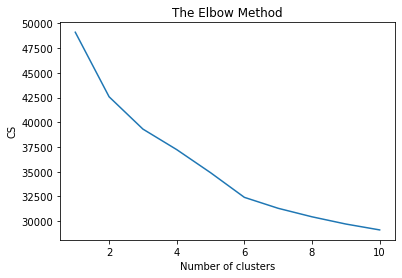

In [69]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(standardized_data)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [70]:
import seaborn as sns
data.columns

Index(['tconst', 'primarytitle', 'startyear', 'runtimeminutes', 'genres',
       'ordering', 'nconst', 'category', 'primaryname', 'primaryprofession',
       'knownfortitles', 'averagerating', 'numvotes', 'directors', 'writers',
       'Cluster'],
      dtype='object')

In [71]:
sns.relplot(
    x="category", y="averageRating", hue="Cluster", data=data, height=6,
);

ValueError: Could not interpret value `averageRating` for parameter `y`

In [ ]:
# Visualization: Communicating Findings


In [ ]:
#TODO look at uniques again
